# Natural language processing analysis of online reviews for small business: extracting insight from small corpora

## Text Analysis on Internet Reviews of Altomontes Italian Market

Author: Benjamin McCloskey

## Import Packages

In [74]:
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist, PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize,sent_tokenize
from gensim import corpora
import gensim
import spacy
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
from gensim import models
import pprint
import tqdm
from wordcloud import WordCloud 
import warnings
warnings.filterwarnings('ignore')

## EDA

In [75]:
#Dataframe with all of the reviews
df = pd.read_csv('Altomontes_reviews.csv')
print("There are a total of " , df.shape[0] ," reviews.")
df.head()

There are a total of  644  reviews.


,Month,Year,Review,Rating,Platform
0,June,2021,Someone in the prep kitchen LOVES salt! The mu...,3,TripAdvisor
1,November,2020,Great looking store in Warminster but...just l...,1,TripAdvisor
2,February,2020,Always friendly workers very helpful and fresh...,5,TripAdvisor
3,February,2020,A local gem which also provides specialty Ital...,4,TripAdvisor
4,January,2020,Countless times I have ordered sandwiches from...,2,TripAdvisor


In [26]:
#Dataframe with only Trip Advisor reviews
df_GR=df[df.Platform == 'Google']
df_GR = df_GR.reset_index() #Resetting the index to start at 0
print("There are {0} reviews that come from {1} .".format(df_GR.shape[0], 'Google Reivews'))

There are 215 reviews that come from Google Reivews .


In [27]:
#Dataframe with only Trip Advisor reviews
df_TA=df[df.Platform == 'TripAdvisor']
df_TA = df_TA.reset_index() #Resetting the index to start at 0
print("There are {0} reviews that come from the {1} Website.".format(df_TA.shape[0], 'TripAdvisor'))

There are 253 reviews that come from the TripAdvisor Website.


In [28]:
#Yelp Review DataFrame
df_yelp = df[df.Platform == 'Yelp']
df_yelp = df_yelp.reset_index()
print("There are {0} reviews that come from the {1} Website.".format(df_yelp.shape[0], 'Yelp'))

There are 176 reviews that come from the Yelp Website.


In [29]:
#Average Rating for the past 10 years
#Overall
print("Average Rating for All Online Reviews :" ,df['Rating'].mean())
print("Average Rating for Yelp Reviews :", df_yelp['Rating'].mean())
print("Average Rating for TripAdvisor Reviews" , df_TA['Rating'].mean())
print('Average Rating for Google Reviews : ', df_GR['Rating'].mean())

Average Rating for All Online Reviews : 4.2313664596273295
Average Rating for Yelp Reviews : 3.6363636363636362
Average Rating for TripAdvisor Reviews 4.4940711462450595
Average Rating for Google Reviews :  4.409302325581395


# Review Analysis

In [30]:
print("Number of each Rating for all of the reviews")
df['Rating'].value_counts()

Number of each Rating for all of the reviews


5    411
4    101
3     49
1     47
2     36
Name: Rating, dtype: int64

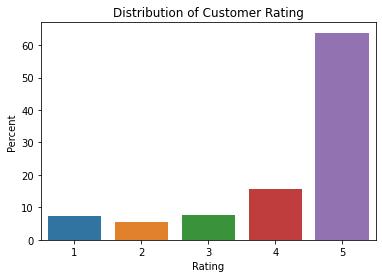

In [31]:
ax = sns.barplot(data=df, x='Rating', y='Rating', estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

# Word Frequency

In [32]:
# function to plot most frequent terms
def frequent_words(x, terms = 30):
    allwords = ' '.join([text for text in x])
    allwords = allwords.split()

    fdist = FreqDist(allwords)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

In [33]:
# remove unwanted characters, numbers and symbols
df['Review'] = df['Review'].str.replace("[^a-zA-Z#]", " ")

# Stopword Function

In [34]:
def remove_stopwords(rev):
    new_review = " ".join([i for i in rev if i not in stop_words])
    return new_review

# remove short words (length < 3)
df['Review'] = df['Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
Reviews = [remove_stopwords(r.split()) for r in df['Review']]

# make entire text lowercase
Reviews = [r.lower() for r in Reviews]

# Lemmatization Function

In [35]:
nlp =spacy.load('en_core_web_sm',disable=['parser','ner'])
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
        output = []
        for sent in texts:
                doc = nlp(" ".join(sent)) 
                output.append([token.lemma_ for token in doc if token.pos_ in tags])
        return output

# Lemmatizaton

In [15]:
Lem_reviews = lemmatization(tokenized_Reviews)
print(Lem_reviews[1])

['great', 'store', 'warminster', 'previous', 'reviewer', 'sandwich', 'order', 'big', 'time', 'live', 'minute', 'italian', 'hoagie', 'oil', 'vinegar', 'roast', 'pork', 'hoagie', 'tomato', 'different', 'beware', 'sandwich', 'order']


# Tokenization Function

In [14]:
#Tokenization
tokenized_Reviews = pd.Series(Reviews).apply(lambda x: x.split())
print(tokenized_Reviews[1])

['great', 'looking', 'store', 'warminster', 'like', 'previous', 'reviewer', 'stated', 'screwed', 'sandwich', 'order', 'big', 'time', 'live', 'minutes', 'away', 'like', 'could', 'return', 'easily', 'ordered', 'italian', 'hoagie', 'oil', 'vinegar', 'got', 'roast', 'pork', 'hoagie', 'tomatoes', 'loaded', 'mayo', 'completely', 'different', 'beware', 'sandwich', 'orders']


# Final Cleaning

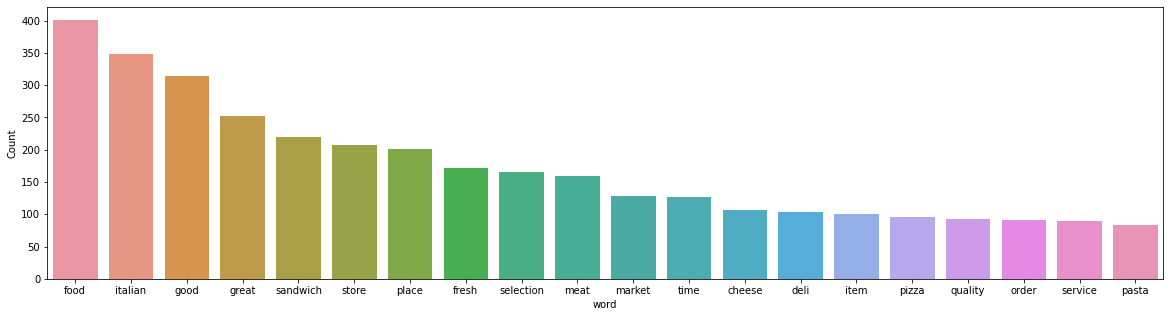

In [16]:
reviews_cleaned = []
for i in range(len(Lem_reviews)):
    reviews_cleaned.append(' '.join(Lem_reviews[i]))

df['Reviews'] = reviews_cleaned

frequent_words(df['Reviews'], 20)

# Visualization

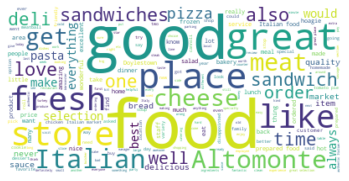

In [17]:
full_text = ' '.join(df['Review'])
cloud_no_stopword = WordCloud(background_color='white', stopwords=stop_words).generate(full_text)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

# Topic Modeling - Overall Corpus

overall_dictionary = corpora.Dictionary(Lem_reviews)

#Converting reviews into a Document Term Matrix
overall_doctermtx = [overall_dictionary.doc2bow(review) for review in Lem_reviews]

LDA = gensim.models.ldamodel.LdaModel

LDA_overall_Model = LDA(corpus=overall_doctermtx, id2word=overall_dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)
LDA_overall_Model.print_topics()

# Coherence Score

In [19]:
coherence_model_overall_lda = CoherenceModel(model=LDA_overall_Model, texts=Lem_reviews, dictionary=overall_dictionary, coherence='c_v')
coherence_overall_lda = coherence_model_overall_lda.get_coherence()
print('Coherence Score: ', coherence_overall_lda)

Coherence Score:  0.38203600918024916


# Perplexity Score

In [20]:
print('\nPerplexity: ', LDA_overall_Model.log_perplexity(overall_doctermtx))  # a measure of how good the model is. lower the better.


Perplexity:  -6.7311834074415335


In [24]:
overall_dictionary = corpora.Dictionary(Lem_reviews)

#Converting reviews into a Document Term Matrix
overall_doctermtx = [overall_dictionary.doc2bow(review) for review in Lem_reviews]

LDA = gensim.models.ldamodel.LdaModel

LDA_overall_Model = LDA(corpus=overall_doctermtx, id2word=overall_dictionary, num_topics=7)
LDA_overall_Model.print_topics( num_topics=7,num_words=5)

[(0,
  '0.029*"good" + 0.020*"italian" + 0.020*"pizza" + 0.014*"item" + 0.014*"food"'),
 (1,
  '0.042*"food" + 0.032*"good" + 0.018*"fresh" + 0.018*"italian" + 0.011*"selection"'),
 (2,
  '0.032*"great" + 0.029*"italian" + 0.024*"sandwich" + 0.020*"selection" + 0.019*"place"'),
 (3,
  '0.042*"food" + 0.030*"italian" + 0.021*"great" + 0.018*"selection" + 0.015*"store"'),
 (4,
  '0.027*"food" + 0.019*"good" + 0.019*"store" + 0.017*"italian" + 0.014*"place"'),
 (5,
  '0.022*"food" + 0.021*"place" + 0.021*"good" + 0.019*"sandwich" + 0.018*"italian"'),
 (6,
  '0.029*"good" + 0.025*"food" + 0.022*"italian" + 0.017*"quality" + 0.015*"great"')]

In [ ]:
coherence_model_overall_lda = CoherenceModel(model=LDA_overall_Model, texts=Lem_reviews, dictionary=overall_dictionary, coherence='c_v')
coherence_overall_lda = coherence_model_overall_lda.get_coherence()
print('Coherence Score: ', coherence_overall_lda)

In [59]:
print('\nPerplexity: ', LDA_overall_Model.log_perplexity(overall_doctermtx))


Perplexity:  -6.8054761248046525


# C-Value Analysis for Number of Topics

In [60]:
def compute_c_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics,)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
compute_c_values(overall_dictionary,overall_doctermtx,Lem_reviews,40)

([<gensim.models.ldamodel.LdaModel at 0x24acaed94c0>,
 [0.34453131193873254,
  0.3846208353690494,
  0.3601149704095168,
  0.3917704535250087,
  0.37196366061401626,
  0.36520726889037736,
  0.4001285587204979,
  0.35565385251968495,
  0.35986312863306635,
  0.39370626676531956,
  0.3762715166887129,
  0.352067523551626,
  0.35876087197596096,
  0.35801997541837066,
  0.3663982509854383,
  0.35994450150162804,
  0.3490868868847812,
  0.3553190184626606,
  0.35130218073760877,
  0.3625760139186803,
  0.3504690247216622,
  0.3513328664575123,
  0.3657852274090798,
  0.3485824958712549,
  0.3430423284695061,
  0.3407943221279795,
  0.34860215242158793,
  0.349683446273753,
  0.3461019024126824,
  0.3556018148168542,
  0.3505686975664484,
  0.3578716234832588,
  0.33554508289315144,
  0.3432250066487687,
  0.34724160924994396,
  0.33240796196146954,
  0.34318884725384574,
  0.3447337789039221])

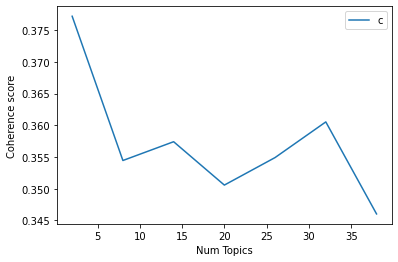

In [85]:
model_list, coherence_values = compute_c_values(dictionary=overall_dictionary, corpus=overall_doctermtx, texts=Lem_reviews, start=2, limit=40, step=6)
# Show graph

import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('7_topics_overall.png')
plt.show()


# Yelp Reviews Analysis

# Word Frequency

In [76]:
# remove unwanted characters, numbers and symbols
df_yelp['Review'] = df_yelp['Review'].str.replace("[^a-zA-Z#]", " ")

In [77]:
# remove short words (length < 3)
df_yelp['Review'] = df_yelp['Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
yelp_Reviews = [remove_stopwords(r.split()) for r in df_yelp['Review']]

# make entire text lowercase
yelp_Reviews = [r.lower() for r in yelp_Reviews]

# Tokenization

In [78]:
tokenized_yelp_Reviews = pd.Series(yelp_Reviews).apply(lambda x: x.split())
print(tokenized_yelp_Reviews[1])

['lifelong', 'resident', 'longterm', 'customer', 'spot', 'italian', 'goods', 'are', 'best', 'you', 'decide', 'our', 'family', 'happy', 'products', 'grocery', 'prepared', 'they', 'cheapest', 'quality', 'pretty', 'high', 'occasional', 'hiccup', 'consistency', 'currently', 'think', 'beloved', 'chicken', 'salad', 'ground', 'fine', 'top', 'area', 'italian', 'hoagie', 'just', 'pizza', 'since', 'become', 'available', 'location', 'thoroughly', 'impressed', 'the', 'crust', 'great', 'flavor', 'thin', 'nice', 'proportion', 'cheese', 'well', 'flavor', 'balance', 'sharpness', 'lightly', 'sweet', 'sauce', 'need', 'try', 'cheesesteak', 'next']


# Lemmatization

In [79]:
Lem_yelp_reviews = lemmatization(tokenized_yelp_Reviews)
print(Lem_yelp_reviews[1])

['lifelong', 'resident', 'longterm', 'customer', 'spot', 'italian', 'good', 'good', 'family', 'happy', 'product', 'grocery', 'cheap', 'quality', 'high', 'occasional', 'hiccup', 'consistency', 'beloved', 'chicken', 'salad', 'ground', 'fine', 'top', 'area', 'italian', 'hoagie', 'pizza', 'available', 'location', 'crust', 'great', 'flavor', 'thin', 'nice', 'proportion', 'cheese', 'balance', 'sweet', 'sauce', 'need']


# Final Cleaning

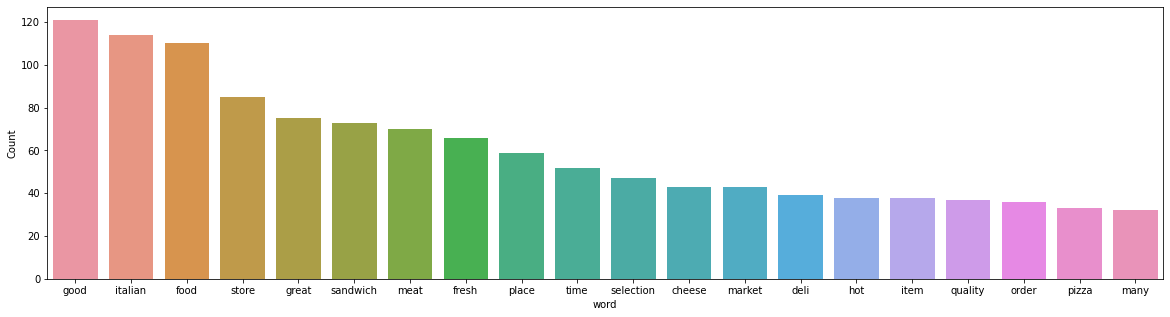

In [80]:
yelp_reviews_cleaned = []
for i in range(len(Lem_yelp_reviews)):
    yelp_reviews_cleaned.append(' '.join(Lem_yelp_reviews[i]))

df_yelp['Reviews'] = yelp_reviews_cleaned

frequent_words(df_yelp['Reviews'], 20)

# Topic Modeling

In [41]:
yelp_dictionary = corpora.Dictionary(Lem_yelp_reviews)

#Converting reviews into a Document Term Matrix
yelp_doctermtx = [yelp_dictionary.doc2bow(review) for review in Lem_yelp_reviews]

LDA = gensim.models.ldamodel.LdaModel

LDA_Yelp_Model = LDA(corpus=yelp_doctermtx, id2word=yelp_dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)
LDA_Yelp_Model.print_topics()

[(0,
  '0.029*"sandwich" + 0.023*"italian" + 0.022*"meat" + 0.019*"great" + 0.016*"fresh" + 0.016*"food" + 0.014*"market" + 0.014*"lunch" + 0.014*"good" + 0.012*"hot"'),
 (1,
  '0.032*"good" + 0.031*"sandwich" + 0.019*"store" + 0.017*"order" + 0.016*"extra" + 0.015*"staff" + 0.014*"hoagie" + 0.014*"quality" + 0.013*"great" + 0.011*"warminster"'),
 (2,
  '0.037*"food" + 0.024*"place" + 0.019*"time" + 0.014*"good" + 0.014*"item" + 0.014*"italian" + 0.013*"great" + 0.012*"staff" + 0.012*"market" + 0.011*"new"'),
 (3,
  '0.021*"italian" + 0.019*"place" + 0.018*"good" + 0.016*"great" + 0.015*"food" + 0.015*"homemade" + 0.014*"sandwich" + 0.014*"tomato" + 0.013*"meat" + 0.013*"pie"'),
 (4,
  '0.026*"good" + 0.024*"time" + 0.020*"meat" + 0.016*"food" + 0.014*"store" + 0.014*"place" + 0.009*"love" + 0.009*"chicken" + 0.009*"customer" + 0.009*"bad"'),
 (5,
  '0.035*"good" + 0.032*"fresh" + 0.014*"food" + 0.012*"homemade" + 0.011*"italian" + 0.008*"store" + 0.008*"choice" + 0.008*"time" + 0.008*

Topic coherence evaluates a single topic by measuring the degree of semantic similarity between high scoring words in the topic. A good model will generate topics with high topic coherence scores.

In [26]:
coherence_model_yelp_lda = CoherenceModel(model=LDA_Yelp_Model, texts=Lem_yelp_reviews, dictionary=yelp_dictionary, coherence='c_v')
coherence_yelp_lda = coherence_model_yelp_lda.get_coherence()
print('Coherence Score: ', coherence_yelp_lda)

Coherence Score:  0.3475713593465577


# TripAdvisor Reviews Analysis

In [42]:
print("Number of Each Rating for the TripAdvisor Reviews")
df_TA['Rating'].value_counts()

Number of Each Rating for the TripAdvisor Reviews


5    168
4     56
3     19
2      6
1      4
Name: Rating, dtype: int64

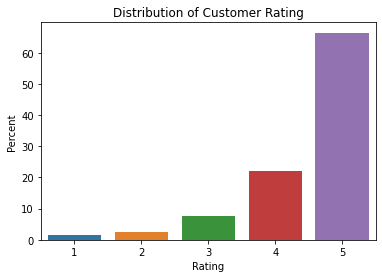

In [43]:
ax = sns.barplot(data=df_TA, x='Rating', y='Rating', estimator=lambda x: len(x) / len(df_TA) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

In [84]:
df_TA['Review'] = df_TA['Review'].str.replace("[^a-zA-Z#]", " ")

In [85]:
# remove short words (length < 3)
df_TA['Review'] = df_TA['Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
TA_Reviews = [remove_stopwords(r.split()) for r in df_TA['Review']]

# make entire text lowercase
TA_Reviews = [r.lower() for r in TA_Reviews]

In [86]:
tokenized_TA_Reviews = pd.Series(TA_Reviews).apply(lambda x: x.split())

In [87]:
lem_TA_reviews = lemmatization(tokenized_TA_Reviews)

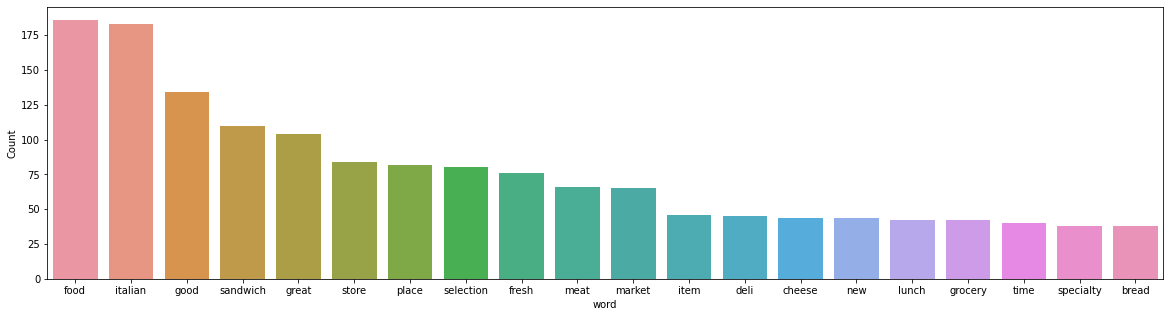

In [117]:
TA_reviews_cleaned = []
for i in range(len(Lem_TA_reviews)):
    TA_reviews_cleaned.append(' '.join(Lem_TA_reviews[i]))

df_TA['Reviews'] = TA_reviews_cleaned

frequent_words(df_TA['Reviews'], 20)

# Topic Modeling

In [118]:
TA_dictionary = corpora.Dictionary(lem_TA_reviews)

#Converting reviews into a Document Term Matrix
TA_doctermtx = [TA_dictionary.doc2bow(review) for review in lem_TA_reviews]

LDA = gensim.models.ldamodel.LdaModel

lda_TA_Model = LDA(corpus=TA_doctermtx, id2word=TA_dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)
lda_TA_Model.print_topics()

[(0,
  '0.034*"food" + 0.013*"problem" + 0.013*"catering" + 0.013*"real" + 0.013*"laura" + 0.012*"product" + 0.009*"delicious" + 0.009*"homemade" + 0.009*"time" + 0.009*"spot"'),
 (1,
  '0.044*"sandwich" + 0.030*"italian" + 0.024*"good" + 0.024*"food" + 0.021*"place" + 0.019*"order" + 0.018*"meat" + 0.017*"time" + 0.017*"lunch" + 0.016*"store"'),
 (2,
  '0.046*"italian" + 0.036*"good" + 0.034*"food" + 0.020*"store" + 0.018*"great" + 0.017*"meal" + 0.017*"area" + 0.016*"place" + 0.014*"hoagie" + 0.014*"sandwich"'),
 (3,
  '0.043*"food" + 0.029*"good" + 0.025*"fresh" + 0.020*"store" + 0.019*"great" + 0.016*"meat" + 0.016*"sandwich" + 0.015*"italian" + 0.014*"place" + 0.014*"love"'),
 (4,
  '0.018*"location" + 0.015*"doylestown" + 0.014*"good" + 0.013*"pepper" + 0.013*"deli" + 0.013*"great" + 0.012*"store" + 0.010*"parking" + 0.010*"offering" + 0.010*"altomonte"'),
 (5,
  '0.033*"store" + 0.030*"food" + 0.030*"italian" + 0.019*"big" + 0.016*"dinner" + 0.014*"place" + 0.014*"new" + 0.010*"

# Google Reviews Analysis

In [119]:
df_GR['Rating'].value_counts()

5    164
4     18
1     17
2      9
3      7
Name: Rating, dtype: int64

In [120]:
df_GR['Review'] = df_GR['Review'].str.replace("[^a-zA-Z#]", " ")

In [121]:
# remove short words (length < 3)
df_GR['Review'] = df_GR['Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
GR_Reviews = [remove_stopwords(r.split()) for r in df_GR['Review']]

# make entire text lowercase
GR_Reviews = [r.lower() for r in GR_Reviews]

In [122]:
tokenized_GR_Reviews = pd.Series(GR_Reviews).apply(lambda x: x.split())

In [123]:
lem_GR_reviews = lemmatization(tokenized_GR_Reviews)

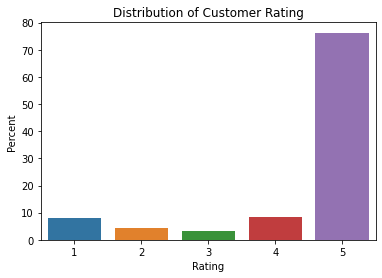

In [124]:
ax = sns.barplot(data=df_GR, x='Rating', y='Rating', estimator=lambda x: len(x) / len(df_GR) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

In [125]:
df_GR['Review'] = df_GR['Review'].str.replace("[^a-zA-Z#]", " ")
stop_words = stopwords.words('english') #specifying the stopwords

#Function for removing stopwords

def stopword_removal(review):
    new_review = " ".join([ i for i in review if i not in stop_words])
    return new_review

#Words with less than 3 letters are being considered not nessecary
df_GR['Review'] = df_GR['Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


#Remove stopwords and make everything lowercase
GR_Reviews = [stopword_removal(r.split()) for r in df_GR['Review']]
GR_Reviews = [r.lower() for r in GR_Reviews]

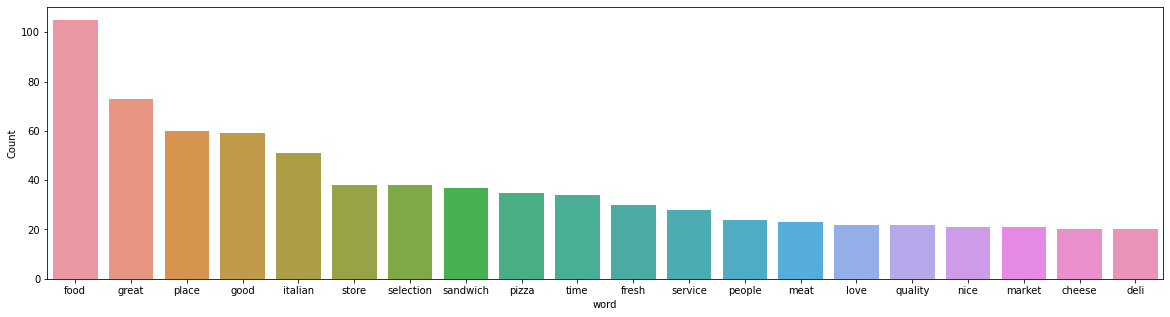

In [126]:
GR_reviews_cleaned = []
for i in range(len(lem_GR_reviews)):
    GR_reviews_cleaned.append(' '.join(lem_GR_reviews[i]))

df_GR['Reviews'] = GR_reviews_cleaned

frequent_words(df_GR['Reviews'], 20)

# Topic Modeling

In [128]:
GR_dictionary = corpora.Dictionary(lem_GR_reviews)

#Converting reviews into a Document Term Matrix
GR_doctermtx = [GR_dictionary.doc2bow(review) for review in lem_GR_reviews]

LDA = gensim.models.ldamodel.LdaModel

lda_GR_Model = LDA(corpus=GR_doctermtx, id2word=GR_dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)
lda_GR_Model.print_topics()

[(0,
  '0.060*"pizza" + 0.024*"love" + 0.022*"customer" + 0.020*"store" + 0.018*"cheese" + 0.018*"sauce" + 0.016*"food" + 0.015*"great" + 0.014*"place" + 0.013*"people"'),
 (1,
  '0.042*"place" + 0.031*"food" + 0.017*"pizza" + 0.017*"sandwich" + 0.015*"lot" + 0.014*"nice" + 0.013*"time" + 0.012*"service" + 0.011*"order" + 0.011*"employee"'),
 (2,
  '0.054*"food" + 0.028*"amazing" + 0.023*"many" + 0.019*"italian" + 0.018*"dinner" + 0.018*"people" + 0.015*"place" + 0.014*"good" + 0.014*"clean" + 0.013*"time"'),
 (3,
  '0.023*"food" + 0.023*"star" + 0.017*"area" + 0.017*"minute" + 0.017*"wine" + 0.014*"store" + 0.012*"staff" + 0.012*"bread" + 0.012*"mask" + 0.012*"pizza"'),
 (4,
  '0.028*"salad" + 0.022*"excellent" + 0.022*"place" + 0.015*"good" + 0.015*"variety" + 0.015*"food" + 0.015*"bad" + 0.015*"glove" + 0.015*"worker" + 0.008*"fresh"'),
 (5,
  '0.104*"great" + 0.078*"food" + 0.053*"selection" + 0.027*"place" + 0.023*"italian" + 0.021*"service" + 0.020*"fresh" + 0.018*"friendly" + 0.